In [3]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.metrics import pairwise_distances

In [4]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'PREP_Kent'

file_path_raw = base_path / 'planilha_kent.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)

In [5]:
# Função para centralizar os dados
def mean_centering(data):
    numeric_data = pd.DataFrame(data).apply(pd.to_numeric, errors='coerce')  # Convertendo valores não numéricos para NaN
    centered_data = numeric_data.sub(numeric_data.mean())  # Subtraindo a média
    return centered_data.values  # Convertendo de volta para numpy array

# Função para calcular variância explicada acumulada
def explained_variance(pca):
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    return explained_variance

# Teste de incerteza jackknife
def jackknife_variance(pca, X):
    loo = LeaveOneOut()
    explained_variances = []

    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        pca.fit(X_train)
        explained_variances.append(explained_variance(pca))

    return np.mean(explained_variances, axis=0), np.std(explained_variances, axis=0)

# Determinar o número ótimo de componentes
def determine_optimal_components(X_centered):
    pca = PCA(n_components=10)
    mean_explained_variance, std_explained_variance = jackknife_variance(pca, X_centered)

    min_diff_index = 0
    
    print(mean_explained_variance)

    for i in range(1, len(mean_explained_variance)):
        diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
        if diff <= 0.009:
            min_diff_index = i - 1  # Armazena o índice anterior
            break
    
    optimal_components = min_diff_index + 1  # Adicionar 1 para obter o número correto de componentes

    return optimal_components, mean_explained_variance, std_explained_variance

# Validar o número ótimo de componentes com Leave-One-Out Cross-Validation
def validate_optimal_components(X, n_components):
    loo = LeaveOneOut()
    errors = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        reconstruction_error = np.linalg.norm(X_test - pca.inverse_transform(X_test_pca))
        errors.append(reconstruction_error)

    return np.mean(errors)

# Detecção de outliers usando Hotelling's T² e F-residual
#def detect_outliers(X, pca, alpha=0.05):
    T2 = np.sum((pca.transform(X) ** 2) / pca.explained_variance_, axis=1)
    Q = np.sum((X - pca.inverse_transform(pca.transform(X))) ** 2, axis=1)
    
    T2_limit = (pca.n_samples_ - 1) * pca.n_components / (pca.n_samples_ - pca.n_components) * \
               f.ppf(1 - alpha, pca.n_components, pca.n_samples_ - pca.n_components)

    outliers = (T2 > T2_limit) | (Q > np.percentile(Q, 100 * (1 - alpha)))

    return outliers, T2, Q, T2_limit

def kennard_stone(data, n_samples):
    # Extrai apenas as colunas relevantes para o cálculo das distâncias
    distances = pairwise_distances(data.iloc[:, 1:].values)
    
    center = np.mean(data.iloc[:, 1:].values, axis=0)

    first_index = np.argmin(np.linalg.norm(data.iloc[:, 1:].values - center, axis=1))
    
    selected_indices = [first_index]

    for _ in range(1, n_samples):
        min_distances = np.min(distances[:, selected_indices], axis=1)
        next_index = np.argmax(min_distances)
        selected_indices.append(next_index)

    # Seleciona os dados completos das amostras selecionadas, incluindo a primeira coluna
    selected_data = data.iloc[selected_indices].copy()
    selected_data_df = pd.DataFrame(selected_data)

    return selected_data_df

# Função para salvar os dados de calibração e validação
def save_calibration_validation_data(calibration_data, validation_data, name):
    calibration_file = f"{name}_calibration.xlsx"
    validation_file = f"{name}_validation.xlsx"
    
    calibration_data.to_excel(calibration_file, index=False)
    validation_data.to_excel(validation_file, index=False)
    
    print(f"Calibration data saved to '{calibration_file}'")
    print(f"Validation data saved to '{validation_file}'")

# Função principal
def main(data, name):
    # Convertendo os dados para um DataFrame com o mesmo índice de df_raw
    df_data = pd.DataFrame(data)
    
    # Adicionando a primeira coluna de df_raw ao df_data
    df_data.insert(0, 'Amostra', df_raw[df_raw.columns[2]])
    
    # Selecionando as colunas da segunda até a quarta e a sexta
    selected_columns = df_raw.columns[2:7].tolist()
    # Inserindo cada coluna selecionada logo após a coluna 'Amostra'
    for i, col in enumerate(selected_columns):
        df_data.insert(i + 1, col, df_raw[col])
    
    new_column_names = df_raw.columns[7:].tolist()
    # Renomeia as colunas da sétima coluna até o final de df_data
    for idx, new_name in enumerate(new_column_names, start=6):
        if idx < len(df_data.columns):
            df_data.columns.values[idx] = new_name

# Verifica o resultado
    print(df_data.columns)

    
    # Aplicando a função mean_centering às colunas numéricas, excluindo a primeira coluna
    #numeric_columns = df_data.columns[7:]  # Exclui a coluna 'Amostra'
    #df_data[numeric_columns] = mean_centering(df_data[numeric_columns].values)

        
    # Determinação do número ótimo de componentes
    optimal_components, mean_explained_variance, std_explained_variance = determine_optimal_components(df_data.iloc[:, 7:].values)
    print(f"Optimal number of components: {optimal_components}")
    
    # Validação do número ótimo de componentes
    cross_val_error = validate_optimal_components(df_data.iloc[:, 7:].values, optimal_components)
    
    # Aplicação do PCA com o número ótimo de componentes
    pca = PCA(n_components=optimal_components)
    pca.fit(df_data.iloc[:, 7:].values)

    # Seleção de amostras usando o método Kennard-Stone
    total_samples = df_data.shape[0]
    n_samples_calibration = int(0.7 * total_samples)

    selected_data_indices = kennard_stone(df_data, n_samples_calibration)
    selected_data_indices = df_data.iloc[selected_data_indices.index].index.tolist()
    selected_data = df_data.loc[selected_data_indices]

    # Cálculo do número de amostras de validação
    n_samples_validation = total_samples - n_samples_calibration
    
    # Criando conjuntos de dados de calibração e validação
    calibration_data = selected_data.sort_values(by='Amostra')
    print("Calibration data:", calibration_data.shape)
    validation_data = df_data[~df_data.index.isin(selected_data.index)]
    validation_data = validation_data.sort_values(by='Amostra')
    print("Validation data:", validation_data.shape)
    
    # Salvando os conjuntos de dados de calibração e validação
    save_calibration_validation_data(calibration_data, validation_data, name)
    
    # Detecção de outliers
    #outliers, T2, Q, T2_limit = detect_outliers(calibration_data.iloc[:, 6:].values, pca)
    
    # Cálculo da variância explicada acumulada para calibração
    pca_calibration = PCA(n_components=optimal_components)
    pca_calibration.fit(mean_centering(calibration_data.iloc[:, 7:].values))
    explained_variances_calibration = explained_variance(pca_calibration)

    # Visualização dos resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(explained_variances_calibration, label='Explained Variance Ratio (Calibration)')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components (Calibration)')
    plt.axvline(optimal_components - 1, color='r', linestyle='--', label=f'Optimal Components: {optimal_components}')
    plt.legend()

    #plt.subplot(1, 2, 2)
    #plt.scatter(T2, Q, c=outliers, cmap='coolwarm', edgecolor='k')
    #plt.axhline(np.percentile(Q, 100 * (1 - 0.027)), color='r', linestyle='--', label=f'Q Limit: {np.percentile(Q, 100 * (1 - 0.02)):.2f}')
    #plt.axvline(T2_limit, color='g', linestyle='--', label=f'T2 Limit: {T2_limit:.2f}')
    #plt.xlabel("Hotelling's T²")
    #plt.ylabel('F-residual')
    #plt.title('Outlier Detection')
    #plt.legend(title='Limits')

    plt.tight_layout()
    plt.show()

    print(f'Optimal number of components: {optimal_components}')
    print(f'Cross-Validation Error: {cross_val_error}')
    #print(f'Outliers detected: {np.sum(outliers)}')
    
    # Verificações de validação
    assert len(calibration_data) == n_samples_calibration, f"Calibration data does not have {n_samples_calibration} samples."
    if len(validation_data) != n_samples_validation:
        raise ValueError(f"Validation data does not have {n_samples_validation} samples. Incorrect selection.")
    
    # Divisão dos componentes entre calibração e validação
    n_calib_components = int(0.7 * optimal_components)
    n_valid_components = optimal_components - n_calib_components
    
    
    # Garantir que o número de componentes para validação seja pelo menos 1
    if n_valid_components < 1:
        n_valid_components = 1
        n_calib_components = optimal_components - n_valid_components
    
    # Aplicar PCA aos conjuntos de dados de calibração e validação
    pca_calibration = PCA(n_components=n_calib_components)
    pca_calibration.fit(calibration_data.iloc[:, 7:].values)
    
    pca_validation = PCA(n_components=n_valid_components)
    pca_validation.fit(validation_data.iloc[:, 7:].values)

Index([   'Amostra',    'FIRMEZA', 'MASSA SECA',       'BRIX',     'ACIDEZ',
              'AAC',   900.577121,   904.475237,   908.369055,   912.258573,
       ...
        1675.187331,  1678.109677,  1681.027723,  1683.941471,  1686.850921,
        1689.756072,  1692.656924,  1694.588437,  1697.482126,  1700.371515],
      dtype='object', length=254)
[0.93660126 0.97789262 0.99781167 0.9993629  0.99965431 0.99975118
 0.99983216 0.99988892 0.99991169 0.99992924]
Optimal number of components: 3
Calibration data: (21, 254)
Validation data: (9, 254)
Calibration data saved to 'RAW_calibration.xlsx'
Validation data saved to 'RAW_validation.xlsx'


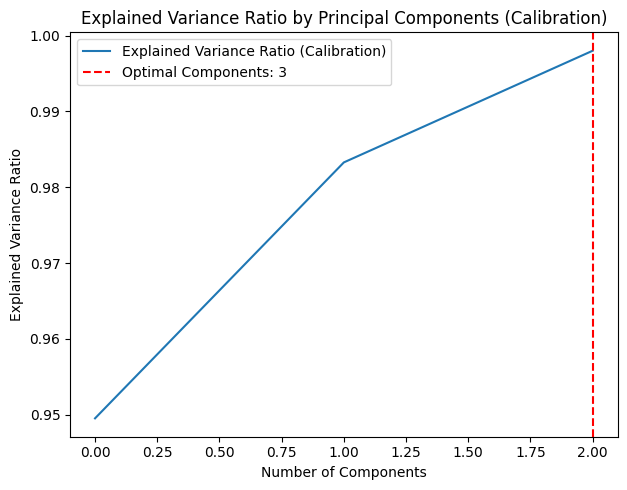

Optimal number of components: 3
Cross-Validation Error: 0.03654196354180914
-------------------------------- 

Index([   'Amostra',    'FIRMEZA', 'MASSA SECA',       'BRIX',     'ACIDEZ',
              'AAC',   900.577121,   904.475237,   908.369055,   912.258573,
       ...
        1675.187331,  1678.109677,  1681.027723,  1683.941471,  1686.850921,
        1689.756072,  1692.656924,  1694.588437,  1697.482126,  1700.371515],
      dtype='object', length=254)
[0.91408689 0.97835756 0.98812248 0.99164283 0.99423635 0.99642206
 0.99730325 0.99787819 0.99827967 0.99859953]
Optimal number of components: 3
Calibration data: (21, 254)
Validation data: (9, 254)
Calibration data saved to 'MSC_calibration.xlsx'
Validation data saved to 'MSC_validation.xlsx'


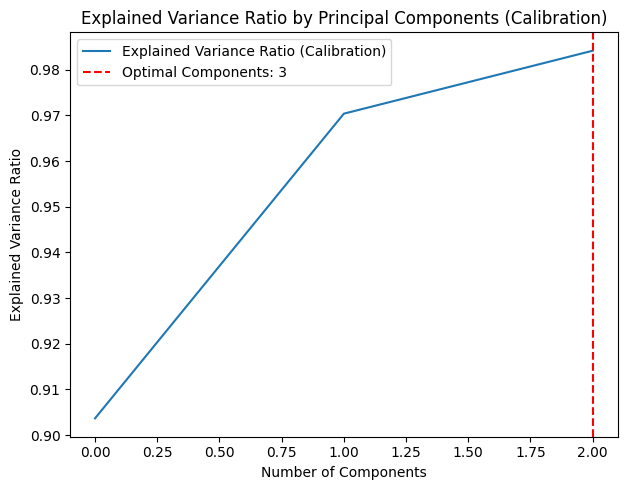

Optimal number of components: 3
Cross-Validation Error: 0.01740954933865539
-------------------------------- 

Index([   'Amostra',    'FIRMEZA', 'MASSA SECA',       'BRIX',     'ACIDEZ',
              'AAC',   900.577121,   904.475237,   908.369055,   912.258573,
       ...
        1675.187331,  1678.109677,  1681.027723,  1683.941471,  1686.850921,
        1689.756072,  1692.656924,  1694.588437,  1697.482126,  1700.371515],
      dtype='object', length=254)
[0.91346449 0.97799866 0.98780673 0.99141547 0.99404859 0.99625151
 0.99715298 0.99779884 0.99820446 0.99856254]
Optimal number of components: 3
Calibration data: (21, 254)
Validation data: (9, 254)
Calibration data saved to 'SNV_calibration.xlsx'
Validation data saved to 'SNV_validation.xlsx'


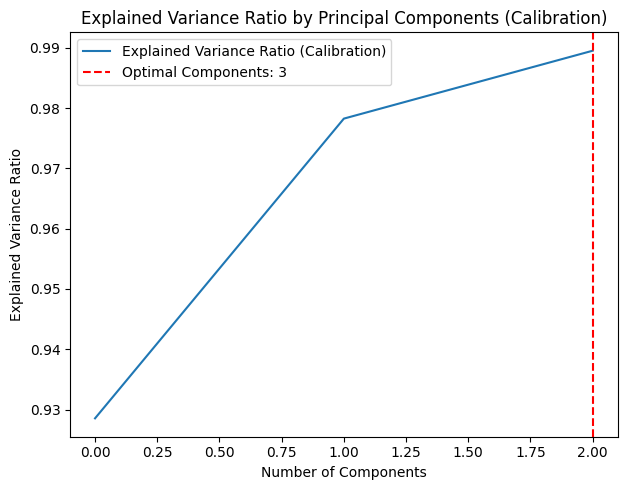

Optimal number of components: 3
Cross-Validation Error: 0.06594166757381328
-------------------------------- 

Index([   'Amostra',    'FIRMEZA', 'MASSA SECA',       'BRIX',     'ACIDEZ',
              'AAC',   900.577121,   904.475237,   908.369055,   912.258573,
       ...
        1675.187331,  1678.109677,  1681.027723,  1683.941471,  1686.850921,
        1689.756072,  1692.656924,  1694.588437,  1697.482126,  1700.371515],
      dtype='object', length=254)
[0.74397215 0.96447835 0.98694755 0.99198356 0.99486544 0.99738235
 0.99911662 0.99948292 0.99968182 0.99985664]
Optimal number of components: 3
Calibration data: (21, 254)
Validation data: (9, 254)
Calibration data saved to 'SG_calibration.xlsx'
Validation data saved to 'SG_validation.xlsx'


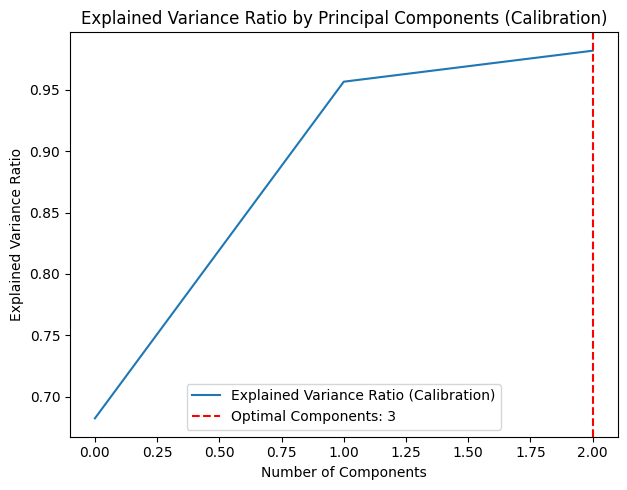

Optimal number of components: 3
Cross-Validation Error: 0.0009114113064599053
-------------------------------- 



In [6]:
names = ['RAW', 'MSC', 'SNV', 'SG']
X_raw = df_raw.iloc[:, 7:].values
X_msc = df_msc.values
X_snv = df_snv.values
X_sg = df_sg.values
datas = [X_raw, X_msc, X_snv, X_sg]

for i in range(len(names)):
    main(datas[i], names[i])
    print("-------------------------------- \n")